<a href="https://colab.research.google.com/github/oliverwsd/finance/blob/master/set5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import scipy.optimize


In [2]:
from io import StringIO
import csv

url = 'https://raw.githubusercontent.com/oliverwsd/finance/master/monthly_factors.csv'
factors = pd.read_csv(url)
factors.head()

,date,rm,rf,SMB,HML,WML
0,196207,-5.53,0.25,-0.29,-1.05,2.38
1,196208,6.11,0.25,-5.50,-1.63,0.80
2,196209,-6.32,0.26,2.26,0.14,1.94
3,196210,-2.03,0.24,-3.12,1.13,1.14
4,196211,19.29,0.24,-0.87,-9.73,-10.36


In [3]:
#factors         = pd.read_csv('monthly_factors.csv')
factors['date'] = pd.to_datetime(factors['date'], format ='%Y%m') # Convert date column to the datetime data type
factors['rm_excess'] = factors['rm'] - factors['rf']
factors = factors[['date', 'rm_excess', 'rf']]  # We'll only use market excess returns and riskfree rate here
factors[['rm_excess', 'rf']] /= 100  # Bring numbers to actual values
factors.head()

,date,rm_excess,rf
0,1962-07-01,-0.0578,0.0025
1,1962-08-01,0.0586,0.0025
2,1962-09-01,-0.0658,0.0026
3,1962-10-01,-0.0227,0.0024
4,1962-11-01,0.1905,0.0024


In [4]:
# Task 1: Estimate AR(1)-ARCH(1) via 2-pass estimation
# ----------------------------------------------------

# We start by estimating the AR(1)-ARCH(1) via a two-pass estimation approach, that is,
# we first estimate the AR model via OLS, then calculate the residuals of that AR(1)
# model and use them to estimate the ARCH(1) part via OLS.
#
# Estimate the AR(1) model for market excess returns via OLS.
#
# Note: 'ar_model' should contain the OLS regression result object (after fitting)
#
# IMPORTANT: Use the constant as first variable in the regression. This also applies to the
#            next regression!

X1 = pd.DataFrame()
rm_excess_x = list(factors['rm_excess'])
rm_excess_y = list(factors['rm_excess'])
X1['alpha'] = np.ones(len(factors['rm_excess'])-1)
X1['beta'] = rm_excess_x[:-1]
Y1 = rm_excess_y[1:]
ar_model = sm.OLS(Y1,X1).fit()

print(ar_model.summary())


# Now, we attack the ARCH(1) part. First, compute the residuals of the AR(1) model that
# you just fitted.
#
ar_model_resid = list(rm_excess_y[1:]- (ar_model.params[0]+factors['rm_excess'][0:-1]*ar_model.params[1]))

# Recall, an ARCH(1) model reads
#     \sigma_t^2 = a + b * \epsilon_{t-1}^2
# with \sigma_t^2 being the variance of \epsilon_t and \epsilon_t is the residual of
# the AR(1) model. We now use \epsilon_t^2 as a very rough measurement for
# \sigma_t^2 (i.e. just replace \sigma_t^2 in the equation above with \epsilon_t^2)
# and estimate the model via OLS.
#
# Please do so next.
#
# Note: 'arch_model' should contain the OLS regression result object (after fitting)
squared_resid = list(map(lambda num:num*num, ar_model_resid))
X2 = pd.DataFrame()
X2['a']= np.ones(len(factors['rm_excess'])-2)
X2['b'] = squared_resid[:-1]
arch_model = sm.OLS(squared_resid[1:],X2).fit()
print(arch_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     6.605
Date:                Fri, 17 Jan 2020   Prob (F-statistic):             0.0104
Time:                        18:59:17   Log-Likelihood:                 964.88
No. Observations:                 617   AIC:                            -1926.
Df Residuals:                     615   BIC:                            -1917.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
alpha          0.0038      0.002      1.833      0.0

In [0]:
# The 2-pass OLS estimation does not generally lead to parameter estimates that maximize
# the (log-)likelihood of the model. Such parameters must be identified via numerical
# optimization. For that, we assume that excess returns r_t are distributed
# normally, with mean \mu_t and volatility \sigma_t. Recall that the likelihood equation
# for the normal distribution reads:
#
#   L(r_t) = (1 / (2 * \pi * \sigma_t^2)^0.5) * e^(-(r_t - \mu_t)^2 / (2 * \sigma_t^2))
#
# This is the likelihood for a single r_t. To get the likelihood of the full time
# series of r_t, we have to multiply the probabilities:
#
#   L(r_{1:T}) = \prod_{t=1}^T L(r_t)
#
# Since a product is hard to compute precisely (all probabilities are < 0, so the product
# will become very small), we just take the log of the likelihood:
#
#   log L(r_{1:T}) = \sum_{t=1}^T log L(r_t)
#
# Before you continue coding, take a pen and paper and derive the log-likelihood formula
# for the AR(1)-ARCH(1) model.
#
# Hint: Recall, in an AR(1) model, the mean prediction is \mu_t = E_{t-1}(r_t) =
#       E(\alpha + \beta * r_{t-1} + \epsilon_t). The variance prediction of the ARCH(1)
#       model is \sigma_t^2 = E_{t-1}(\epsilon_t^2) = E(a + b * \epsilon_{t-1}^2).
#       Plug these formulas into the equations above. Since you make each forecast for time t
#       in t-1, you can use everything that is known in t-1 as an observed variable (i.e. not
#       a random number any more.


# Once you derived the log-likelihood formula, implement it in the function below. The function
# should calculate the log-likelihood of the observed excess returns, given a set of parameters.
#
# Note: Since you need the first AR(1)-residual \epsilon_1 for the variance forecast, skip
#       the very first return in the actual log-likelihood calculation.
# Hint: You can get \pi as math.pi

#mu_t = ar_model.params[0]+factors['rm_excess'][0:-1]*ar_model.params[1]

def loglikelihood_ar_arch(parameters):   # Parameters is a list of model parameters, here: [\alpha, \beta, a, b]
    ar_alpha = parameters[0]
    ar_beta = parameters[1]
    arch_a = parameters[2]
    arch_b = parameters[3]
    loglikeli = 0
    for i in range(1,factors.shape[0]):
      prob = -0.5*np.log(math.pi*2) - 0.5* np.log(arch_a / (1 - arch_b)) - 0.5*(( rm_excess_x[i] - (ar_alpha + ar_beta * rm_excess_x[i-1]) )**2/(arch_a / (1-arch_b)))
      loglikeli += prob

    return -loglikeli  # We return the negative log-likelihood. This is intentional, you'll see in a moment, why.

#def 式子有错
# np.log = math.log
# params 暂时不考虑
# 看式子本身: i length; derivation equatation;

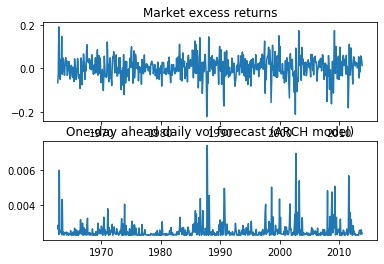

In [42]:
# minimize 
ar_arch_params_start = [ar_model.params[0],ar_model.params[1],arch_model.params[0],arch_model.params[1]]
ar_arch_params = scipy.optimize.minimize(loglikelihood_ar_arch, ar_arch_params_start, method= 'Nelder-Mead')
# Method Nelder-Mead cannot handle constraints nor bounds.
# Given the optimal model parameters, compute the volatility (!) forecast of the model.
#
ar_arch_params.x
new_resid = rm_excess_x[1:]- ( ar_arch_params.x[0] + factors['rm_excess'][:-1]* ar_arch_params.x[1])
new_squared_resid = list(map(lambda num: num*num, new_resid))

arch_vol_forecasts =  ar_arch_params.x[2] + ar_arch_params.x[3]* np.array(new_squared_resid[:-1])  # Hint: type(arch_vol_forecasts) should be np.ndarray and arch_vol_forecasts.shape should be (616,)

# Now, let's plot the vol forecasts
fig, ax = plt.subplots(2, 1)
ax[0].plot(factors['date'].iloc[2:], factors['rm_excess'].iloc[2:])
ax[0].set_title("Market excess returns")
ax[1].plot(factors['date'].iloc[2:], arch_vol_forecasts)
ax[1].set_title("One-day ahead daily vol forecast (ARCH model)")
plt.show()

In [41]:
loglikelihood_ar_arch([0.01, 0.2, 0.01, 0.1])
#my answer is -748 should be -766.19 
ar_arch_params.x[0]
# should be 0,0045
arch_vol_forecasts[0]
#0,0514

0.002682971908395779

In [0]:
# Task 3: MLE estimation of AR(1)-GARCH(1, 1) model
# -------------------------------------------------

# The GARCH model is similar to the ARCH model, but also makes the variance forecast for
# tomorrow depend on the variance forecast of today:
#    \sigma_t^2 = a + b * \epsilon_{t-1}^2 + c * \sigma_{t-1}^2
#
# Write a function that calculates the time series for \sigma_t based on given parameters
# a, b, c, an initial value for \sigma^2 and a time series of epsilon_t.
#
# Hint: Use a for-loop.
# Note: Do not create a \sigma^2 estimate based on the last \epsilon observation. This would
#       create a forecast for the first return after our observed data sample. We don't want that.
#

def garch_variance(a, b, c, sigma_initial, epsilon):
    sigma2 =
    return sigma2

test_garch_variance =  garch_variance(0.01, 0.15, 0.8, 0.2, ar_model_resid)    # Hint: type(test_garch_variance) should be np.ndarray
                                                                               # Hint: test_garch_variance.shape should be (616,)

# How write a function that calculates the log-likelihood of excess returns in an AR(1)-GARCH(1,1) model
# based on the variance forecast of the GARCH model. Follow the same reasoning
# and procedure as for the ARCH model above.
#
def loglikelihood_ar_garch(parameters):
    ar_alpha = parameters[0]
    ar_beta = parameters[1]
    garch_a = parameters[2]
    garch_b = parameters[3]
    garch_c = parameters[4]
    garch_initial_sigma = parameters[5]

    loglikeli =

    return -loglikeli  # We return the negative log-likelihood. This is intentional, you'll see in a moment, why.

# Now, again, use the scipy.optimize.minimize function to find the optimal
# parameters of the AR(1)-GARCH(1,1) model.
#
# Again, use method = 'Nelder-Mead' in the scipy.optimize.minimize(...) function.
#
ar_garch_params_start = [ar_model.params[0], ar_model.params[1], 0.0001, 0.15, 0.8, np.var(factors['rm_excess'])]
ar_garch_params =

# Given the optimal model parameters, compute the volatility (!) forecast of the GARCH(1,1) model.
#

garch_vol_forecasts =       # Hint: type(garch_vol_forecasts) should be np.ndarray and garch_vol_forecasts.shape should be (616,)

# Now, let's plot the vol forecasts
fig, ax = plt.subplots(2, 1)
ax[0].plot(factors['date'].iloc[2:], factors['rm_excess'].iloc[2:])
ax[0].set_title("Market excess returns")
ax[1].plot(factors['date'].iloc[2:], arch_vol_forecasts, label = 'ARCH model vol forecast')
ax[1].plot(factors['date'].iloc[2:], garch_vol_forecasts, label = 'GARCH model vol forecast')
ax[1].set_title("One-day ahead daily vol forecast")
ax[1].legend()
plt.show()


# Check of intermediate result (3):
#
# HINT: Check for yourself: test_garch_variance[0] should be 0.1706 (rounded to 4 digits)
#       Check for yourself: loglikelihood_ar_garch([0.001, 0.15, 0.0002, 0.3, 0.65, 0.001]) should be -974.81 (rounded to 2 digits)
#       Check for yourself: ar_garch_params.x[0] should be 0.0038  (rounded to 4 digits)
#       Check for yourself: garch_vol_forecasts[0] should be 0.1086 (rounded to 4 digits)